# Multiple dispatch

**Multiple dispatch** is a key feature of Julia, that we will explore in this notebook.

It helps make software fast. It also makes software extensible, programmable, and downright fun to play with. 

1. Roman numerals
2. Functions

## 1. Roman numerals (for fun)

Let's define a **new struct** that represents a Roman numeral. For coding simplicity, we'll just deal with numbers between 0 and 9. 

**Exercise**: Extend this to larger numbers. (Recall that Roman numbers are a base-10 system!)

In [1]:
struct Roman
    n::Int
end

Base.show(io::IO, r::Roman) = print(io, 'ⅰ' + (r.n - 1) % 10 )  # nice display; 'ⅰ' is a Unicode Roman numeral

We can create an object of this type as follows:

In [2]:
Roman(4)

ⅳ

In [3]:
typeof.([5 5.0 Roman(5) "Five" '5'  5//1])

1×6 Array{DataType,2}:
 Int64  Float64  Roman  String  Char  Rational{Int64}

We would like to display it nicely, in Roman numerals:

In [4]:
x = [7 1 2 5 8 9]
Roman.(x)   # equivalent to map(Roman, x)  or  [Roman(w) for w in x]

1×6 Array{Roman,2}:
 ⅶ  ⅰ  ⅱ  ⅴ  ⅷ  ⅸ

It'd be nice to be able to add Roman numerals together like normal numbers:

In [5]:
Roman(4) + Roman(5)

MethodError: MethodError: no method matching +(::Roman, ::Roman)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529

But Julia doesn't know how to do that. Let's teach it by `import`ing the `+` function, which then allows us to _extend_ its definition:

In [6]:
import Base: +, *

+(a::Roman, b::Roman) = Roman(a.n + b.n)

+ (generic function with 162 methods)

In [7]:
Roman(4) + Roman(5)

ⅸ

This **adds a new method** to the function `+`:

In [ ]:
methods(+)

In [9]:
import Base.*
*(i::Roman, j::Roman) = Roman(i.n * j.n)                     # Multiply like a Roman

* (generic function with 355 methods)

In [10]:
Roman(3) * Roman(2)

ⅵ

In [11]:
Roman.(1:3) .* [Roman(1) Roman(2) Roman(3)]

3×3 Array{Roman,2}:
 ⅰ  ⅱ  ⅲ
 ⅱ  ⅳ  ⅵ
 ⅲ  ⅵ  ⅸ

But 

In [12]:
Roman(3) * 2

MethodError: MethodError: no method matching *(::Roman, ::Int64)
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  *(!Matched::Complex{Bool}, ::Real) at complex.jl:301
  *(!Matched::Missing, ::Number) at missing.jl:94
  ...

In [13]:
# Complex function `mytimes` to decide what to do based on type
# This is not suggested, better way coming soon

function mytimes(i,j)
  if isa(i,Roman) & isa(j,Number)
        return  fill(1, i.n, j)   # i by j matrix with ones
    elseif    isa(i,Number) & isa(j,Roman) 
        return "😄"^ (i*j.n)   #  i * j happy faces
    else
        return("I Don't know")
    end
end

mytimes (generic function with 1 method)

In [14]:
mytimes(4,Roman(3)) # Twelve happys

"😄😄😄😄😄😄😄😄😄😄😄😄"

In [15]:
mytimes(Roman(4),3) # 4x3 matrix with ones

4×3 Array{Int64,2}:
 1  1  1
 1  1  1
 1  1  1
 1  1  1

The simplest thing to do is to explicitly define multiplication of a `Roman` by a number. We can do it as we see fit:

In [16]:
*(i::Number, j::Roman) = "😄"^ (i*j.n)        #  i * j happy faces

*(i::Roman, j::Number) =   fill(1, i.n, j)       # i by j matrix

* (generic function with 357 methods)

In [17]:
3 * Roman(3) # Nine happys

"😄😄😄😄😄😄😄😄😄"

In [18]:
Roman(3) * 5  # Three by Five matrix of ones

3×5 Array{Int64,2}:
 1  1  1  1  1
 1  1  1  1  1
 1  1  1  1  1

In [19]:
t(x::Roman,y::Roman) = x.n * y.n

t (generic function with 1 method)

In [20]:
t(Roman(5),Roman(4))

20

In [21]:
#  Notice how tight the assembler is!
@code_native t(Roman(2),Roman(4))

	.text
; ┌ @ In[19]:1 within `t'
	pushq	%rbp
	movq	%rsp, %rbp
; │┌ @ int.jl:54 within `*'
	movq	(%rdx), %rax
	imulq	(%rcx), %rax
; │└
	popq	%rbp
	retq
	nopl	(%rax)
; └


## Functions

In [3]:
import Base: *, +, ^

In [4]:
*(α::Number,   g::Function) = x -> α * g(x)   # Scalar times function

*(f::Function, λ::Number)   = x -> f(λ * x)   # Scale the argument

*(f::Function, g::Function) = x -> f(g(x))    # Function composition  -- abuse of notation!  use \circ in Julia 0.6

^(f::Function, n::Integer) = n == 1 ? f : f*f^(n-1) # A naive exponentiation algorithm by recursive multiplication

^ (generic function with 67 methods)

In [5]:
+(f::Function, g::Function) = x -> f(x) + g(x)

+ (generic function with 187 methods)

In [6]:
f = x -> x^2
f(10)

100

In [7]:
g = 3f
g(10)

300

In [8]:
(f^2)(10)  # since we defined multiplication of functions as composition

10000

In [1]:
using Plots;
gr()

Plots.GRBackend()

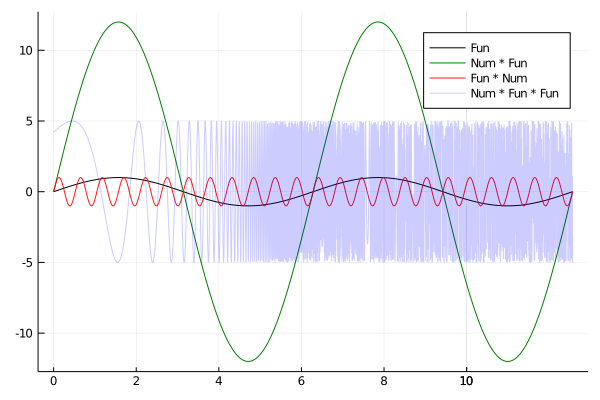

In [9]:
x = pi*(0:0.001:4)

plot(x, sin.(x),    c="black", label="Fun")
plot!(x, (12*sin).(x),    c="green", label="Num * Fun")
plot!(x, (sin*12).(x),    c="red", alpha=0.9, label="Fun * Num")
plot!(x, (5*sin*exp).(x), c="blue", alpha=0.2, label="Num * Fun * Fun")

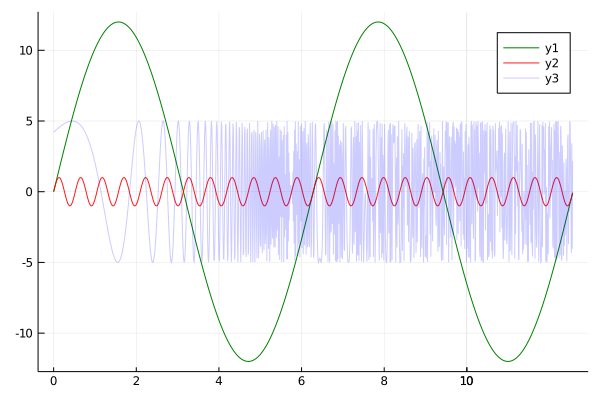

In [10]:
plot([12*sin, sin*12, 5*sin*exp], 0:.01:4π, α=[1 .9 .2], c=[:green :red :blue])

${{sin^2}\phi}$ is odious to me, even though Laplace made use of it; should  it be feared that ${{sin^2}\phi}$ might become ambiguous, which would perhaps  never occur, or at most very rarely when speaking of ${{sin}(\phi^2)}$, well  then, let us write ${(sin phi)^2}$, but not ${sin^2 \phi}$, which by analogy  should signify ${sin(sin \phi)}$." -- Gauss

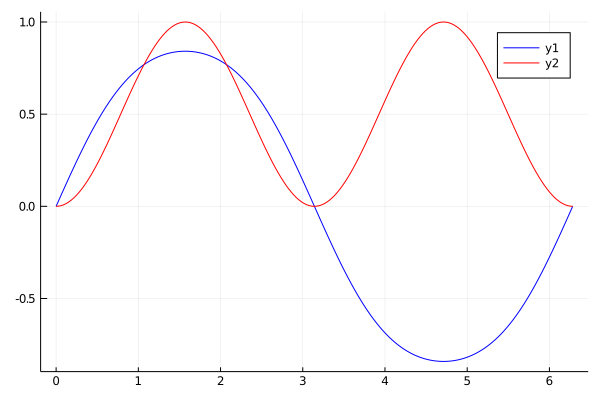

In [11]:
x=(0:.01:2) * pi;

plot(x, (sin^2).(x), c="blue")     # Squaring just works, y=sin(sin(x)), Gauss would be pleased!
plot!(x, sin.(x).^2,  c="red")         

The exponential function is defined as

$$\exp(x) = \sum_{n=0}^\infty \frac{1}{n!} x^n.$$

We can think of this just in terms of functions:

$$\exp = \sum_{n=0}^\infty \frac{1}{n!} \mathrm{pow}_n,$$

where $\mathrm{pow}_n(x) = x^n$.

(starts to blur the symbolic with the numerical!)

In [12]:
pow(n) = x -> x^n

myexp = sum(1/factorial(big(n)) * pow(n) for n in 0:100)   # taylor series not efficient!

#9 (generic function with 1 method)

In [13]:
[myexp(1); exp(1); exp(big(1))]

3-element Array{BigFloat,1}:
 2.718281828459045235360287471352662497757247093699959574966967627724076630353416
 2.718281828459045090795598298427648842334747314453125
 2.718281828459045235360287471352662497757247093699959574966967627724076630353555

# Exercise

In [34]:
h(a, b::Any) = "fallback"
h(a::Number, b::Number) = "a and b are both numbers"
h(a::Number, b) = "a is a number"
h(a, b::Number) = "b is a number"
h(a::Integer, b::Integer) = "a and b are both integers"

h (generic function with 5 methods)

In [35]:
# Try playing with h